In [1]:
import pandas as pd
import numpy as np
from pathlib import Path

In [2]:
# === 1) Set your file paths here ===
CSV_PATHS = [
    "resources/dataset_project_eHealth20252026.csv",
    "resources/questionnaire_codebook_eHealth20252026.csv",
]
 
# (Optional) If you know the ID column name, set it here; otherwise the code will try to guess.
KNOWN_ID_COL = None  # e.g., "ID" or "RespondentID" or "participant_id"


In [3]:
# === 2) Helper: robust CSV loader (handles common encodings/delimiters) 
def load_csv_robust(path: str) -> pd.DataFrame:
    path = Path(path)
    if not path.exists():
        raise FileNotFoundError(f"File not found: {path}")
    # Try default; if it fails, try common alternatives
    trials = [
        dict(encoding=None, sep=None, engine="python"),          # auto-detect sep
        dict(encoding="utf-8", sep=None, engine="python"),
        dict(encoding="latin-1", sep=None, engine="python"),
        dict(encoding=None, sep=",", engine="python"),
        dict(encoding=None, sep=";", engine="python"),
    ]
    last_err = None
    for kw in trials:
        try:
            return pd.read_csv(path, **kw)
        except Exception as e:
            last_err = e
    raise RuntimeError(f"Could not read {path} – last error:\n{last_err}")
 

In [4]:
# === 3) Load both CSVs and show basic info ===
for p in CSV_PATHS:
    df = load_csv_robust(p)
    print(f"\n=== Loaded: {p} ===")
    print(f"Shape: {df.shape[0]} rows × {df.shape[1]} cols")
    print("First 20 column names:", list(df.columns[:20]))
    print("\nDtypes:")
    print(df.dtypes.head(15))


=== Loaded: resources/dataset_project_eHealth20252026.csv ===
Shape: 221 rows × 96 cols
First 20 column names: ['age', 'gender', 'education', 'marital', 'income', 'audit_1', 'audit_2', 'audit_3', 'audit_4', 'audit_5', 'audit_6', 'audit_7', 'audit_8', 'audit_9', 'audit_10', 'dast_1', 'dast_2', 'dast_3', 'dast_4', 'dast_5']

Dtypes:
age          float64
gender         int64
education    float64
marital      float64
income         int64
audit_1        int64
audit_2        int64
audit_3      float64
audit_4        int64
audit_5      float64
audit_6        int64
audit_7      float64
audit_8      float64
audit_9      float64
audit_10     float64
dtype: object

=== Loaded: resources/questionnaire_codebook_eHealth20252026.csv ===
Shape: 96 rows × 4 cols
First 20 column names: ['\ufeffquestion', 'type', 'name of column', '[codification] options (if applicable)']

Dtypes:
﻿question                                 object
type                                      object
name of column            

We need to do some cleaning in dataset csv 
For the Nan values, replace NaN with the mean values of that question

Each prefix is the abbreviation for a different questionnaire or scale:

audit: Alcohol Use Disorders Identification Test

dast: Drug Abuse Screening Test

pgsi: Problem Gambling Severity Index

iat: Internet Addiction Test

pcl5: PTSD Checklist for DSM-5

mspss: Multidimensional Scale of Perceived Social Support

swls: Satisfaction With Life Scale

who5: WHO-5 Well-Being Index

In [5]:
questionnaires = [
    "audit",
    "dast",
    "pgsi",
    "iat",
    "pcl5",
    "mspss",
    "swls",
    "who5"
]

In [6]:
#Clean data

dataset = load_csv_robust(CSV_PATHS[0])
nan_rows_df1 = dataset.isna().any(axis=1).sum()

print(f"NaN rows in df1: {nan_rows_df1}")

# Suppose your DataFrame is called dataset
flag_nan_or_empty = dataset.isna() | (dataset == "")
nan_or_empty_rows = dataset.index[flag_nan_or_empty.any(axis=1)].tolist()

print(f"Rows with NaN or empty string values: {nan_or_empty_rows}")

NaN rows in df1: 67
Rows with NaN or empty string values: [2, 6, 8, 13, 17, 18, 28, 29, 31, 35, 37, 39, 49, 53, 57, 59, 61, 62, 64, 66, 68, 69, 74, 79, 82, 83, 88, 91, 92, 95, 96, 100, 105, 107, 109, 110, 111, 114, 115, 116, 117, 120, 122, 129, 132, 133, 140, 141, 142, 149, 151, 156, 157, 162, 165, 170, 173, 181, 183, 195, 199, 201, 204, 206, 214, 215, 219]


In [7]:
df_filled = dataset.copy()

# Get only the questionnaire columns (skipping demographic first 5)
questionnaire_cols = dataset.columns[5:]

for q in questionnaires:
    q_cols = [col for col in questionnaire_cols if col.startswith(q + "_")]
    dataset[q_cols] = dataset[q_cols].replace("", np.nan)
    dataset[q_cols] = dataset[q_cols].apply(pd.to_numeric, errors='coerce')
    for idx, row in dataset.iterrows():
        med = row[q_cols].median(skipna=True)
        df_filled.loc[idx, q_cols] = row[q_cols].fillna(med)

# Save the filled dataset locally with a new name
df_filled.to_csv('filled_personal_medians.csv', index=False)

In [8]:
#Clean data

nan_rows_df1 = df_filled.isna().any(axis=1).sum()

print(f"NaN rows in df1: {nan_rows_df1}")


NaN rows in df1: 3


Filling numerical Nan values age and income with median and categorical with mode

In [9]:
# Učitaj postojeći fajl
df = pd.read_csv("filled_personal_medians.csv")

cols_to_fill = ["age", "gender", "education", "marital", "income"]

print("NaN BEFORE filling:\n", df[cols_to_fill].isna().sum(), "\n")

for col in cols_to_fill:
    if col not in df.columns:
        print(f"⚠️ Column '{col}' not found, skipping.")
        continue

    # Ako je numerička kolona → popuni medianom
    if pd.api.types.is_numeric_dtype(df[col]):
        med = df[col].median(skipna=True)
        df[col] = df[col].fillna(med)
        print(f"✅ {col}: filled NaN with median = {med}")

    else:
        # Ako je kategorijska → popuni modom (najčešćom vrednošću)
        s = df[col].astype("string").str.strip()
        s = s.replace({"": pd.NA, "nan": pd.NA, "None": pd.NA})
        mode_vals = s.mode(dropna=True)
        if len(mode_vals) > 0:
            mode_val = mode_vals[0]
            df[col] = s.fillna(mode_val)
            print(f"✅ {col}: filled NaN with mode = '{mode_val}'")
        else:
            df[col] = s.fillna("Unknown")
            print(f"ℹ️ {col}: all values were NaN → filled with 'Unknown'")

print("\nNaN AFTER filling:\n", df[cols_to_fill].isna().sum())

# 💾 Prepiši originalni fajl (overwrite)
df.to_csv("filled_personal_medians.csv", index=False)
print("\n✅ Updated 'filled_personal_medians.csv' saved — all NaN values replaced.")


NaN BEFORE filling:
 age          1
gender       0
education    1
marital      1
income       0
dtype: int64 

✅ age: filled NaN with median = 29.0
✅ gender: filled NaN with median = 1.0
✅ education: filled NaN with median = 13.0
✅ marital: filled NaN with median = 1.0
✅ income: filled NaN with median = 25000.0

NaN AFTER filling:
 age          0
gender       0
education    0
marital      0
income       0
dtype: int64

✅ Updated 'filled_personal_medians.csv' saved — all NaN values replaced.


In [ ]:
personal_cols = ["age", "gender", "education", "marital", "income"]

print("\n=== Basic stats for first 5 personal columns ===")
for col in personal_cols:
    if col not in df.columns:
        print(f"⚠️ Column '{col}' not found in dataset — skipping.")
        continue
    
    # ako je numerička kolona → prikaz min i max
    if pd.api.types.is_numeric_dtype(df[col]):
        col_min = df[col].min(skipna=True)
        col_max = df[col].max(skipna=True)
        print(f"{col}: min = {col_min}, max = {col_max}")
    else:
        # ako je kategorijska kolona → prikaži broj unikatnih i top 3 vrednosti
        unique_vals = df[col].dropna().unique()
        print(f"{col}: {len(unique_vals)} unique values → {df[col].value_counts().head(3).to_dict()}")


=== Basic stats for first 5 personal columns ===
age: min = 18.0, max = 40.0
gender: min = 0, max = 3
education: min = 5.0, max = 25.0
marital: min = 0.0, max = 5.0
income: min = 10000, max = 96600


In [13]:
from scipy import stats
# ✅ Assuming df is already loaded and first 5 columns are personal info
excluded_cols = ["age", "gender", "education", "marital", "income"]

# Select only numeric questionnaire columns (excluding first 5)
questionnaire_cols = [
    c for c in df.columns
    if c not in excluded_cols and pd.api.types.is_numeric_dtype(df[c])
]

print(f"Number of questionnaire columns: {len(questionnaire_cols)}")

# Compute z-scores for those columns
z_scores = np.abs(stats.zscore(df[questionnaire_cols], nan_policy='omit'))

# Create a boolean mask of outliers (|z| > 3)
outlier_mask = (z_scores > 3)

# Count outliers per column
outlier_counts = pd.DataFrame({
    "num_outliers": outlier_mask.sum(axis=0).astype(int),
    "percent_outliers": (outlier_mask.sum(axis=0) / len(df) * 100).round(2)
})

print("\n=== Outlier Summary (|z| > 3) ===")
display(outlier_counts.sort_values("num_outliers", ascending=False).head(20))

# Optional: mark rows that have at least one outlier
df["has_outlier"] = outlier_mask.any(axis=1)

print(f"\nRows with at least one outlier: {df['has_outlier'].sum()} of {len(df)} total")

# Optional: Save summary
# outlier_counts.to_csv("outlier_summary_questionnaires.csv")

Number of questionnaire columns: 91

=== Outlier Summary (|z| > 3) ===


,num_outliers,percent_outliers
0,0,0.0
1,0,0.0
2,0,0.0
3,0,0.0
4,0,0.0
5,0,0.0
6,0,0.0
7,0,0.0
8,0,0.0
9,0,0.0



Rows with at least one outlier: 0 of 221 total


In [17]:
# 1) Load the file you want to modify
df = pd.read_csv("filled_personal_medians.csv")

# 2) Define a safe selector: only questions like AUDIT_1, AUDIT_2, ...
def compute_total(prefix):
    cols = [c for c in df.columns if c.upper().startswith(prefix + "_")]
    print(f"{prefix}: found {len(cols)} item columns ->", cols[:10], "..." if len(cols) > 10 else "")
    if cols:
        # convert to numeric just in case
        df[cols] = df[cols].apply(pd.to_numeric, errors="coerce")
        df[f"{prefix}_total"] = df[cols].sum(axis=1, skipna=True)
        print(f"{prefix}_total added.")
    else:
        print(f"No columns found for {prefix} (check column names).")

# 3) Compute totals for all instruments you have
for prefix in ["AUDIT", "DAST", "IAT", "PGSI", "PCL5", "MSPSS", "SWLS", "WHO5"]:
    compute_total(prefix)

# 4) Quick verification in-memory
print(df[[c for c in df.columns if c.endswith("_total")]].head())

# 5) Save back OVER the same CSV
df.to_csv("filled_personal_medians.csv", index=False)

# 6) Optional: re-load to confirm it persisted
check = pd.read_csv("filled_personal_medians.csv")
print("Totals present after reload:", [c for c in check.columns if c.endswith("_total")])

AUDIT: found 11 item columns -> ['audit_1', 'audit_2', 'audit_3', 'audit_4', 'audit_5', 'audit_6', 'audit_7', 'audit_8', 'audit_9', 'audit_10'] ...
AUDIT_total added.
DAST: found 11 item columns -> ['dast_1', 'dast_2', 'dast_3', 'dast_4', 'dast_5', 'dast_6', 'dast_7', 'dast_8', 'dast_9', 'dast_10'] ...
DAST_total added.
IAT: found 21 item columns -> ['iat_1', 'iat_2', 'iat_3', 'iat_4', 'iat_5', 'iat_6', 'iat_7', 'iat_8', 'iat_9', 'iat_10'] ...
IAT_total added.
PGSI: found 10 item columns -> ['pgsi_1', 'pgsi_2', 'pgsi_3', 'pgsi_4', 'pgsi_5', 'pgsi_6', 'pgsi_7', 'pgsi_8', 'pgsi_9', 'PGSI_total'] 
PGSI_total added.
PCL5: found 21 item columns -> ['pcl5_1', 'pcl5_2', 'pcl5_3', 'pcl5_4', 'pcl5_5', 'pcl5_6', 'pcl5_7', 'pcl5_8', 'pcl5_9', 'pcl5_10'] ...
PCL5_total added.
MSPSS: found 13 item columns -> ['mspss_1', 'mspss_2', 'mspss_3', 'mspss_4', 'mspss_5', 'mspss_6', 'mspss_7', 'mspss_8', 'mspss_9', 'mspss_10'] ...
MSPSS_total added.
SWLS: found 6 item columns -> ['swls_1', 'swls_2', 'swls_3

making a new db just with total values and first 5 columns

In [18]:
# Select the personal columns (first 5)
personal_cols = ["age", "gender", "education", "marital", "income"]

# Select all total score columns (those ending with "_total")
total_cols = [c for c in df.columns if c.endswith("_total")]

# Combine them
columns_to_keep = personal_cols + total_cols

# Create a new DataFrame
df_totals = df[columns_to_keep].copy()

# Quick check
print(df_totals.head())

# Save to a new CSV file
output_name = "totals_with_personal_info.csv"
df_totals.to_csv(output_name, index=False)
print(f"Saved new dataset: {output_name}")

    age  gender  education  marital  income  AUDIT_total  DAST_total  \
0  39.0       0        8.0      1.0   14000         50.0         0.0   
1  18.0       1        5.0      1.0   25000         32.0         0.0   
2  40.0       0       13.0      2.0   56000          0.0        16.0   
3  24.0       1       22.0      0.0   35000         14.0        16.0   
4  19.0       1       22.0      1.0   42000         28.0         8.0   

   IAT_total  PGSI_total  PCL5_total  MSPSS_total  SWLS_total  WHO5_total  
0       78.0        48.0         0.0        102.0        16.0        26.0  
1       66.0        16.0        12.0         86.0        28.0        14.0  
2      120.0         0.0       100.0         36.0        16.0        26.0  
3      112.0         0.0       126.0         52.0        30.0        22.0  
4        0.0         2.0        16.0        122.0        54.0        40.0  
Saved new dataset: totals_with_personal_info.csv


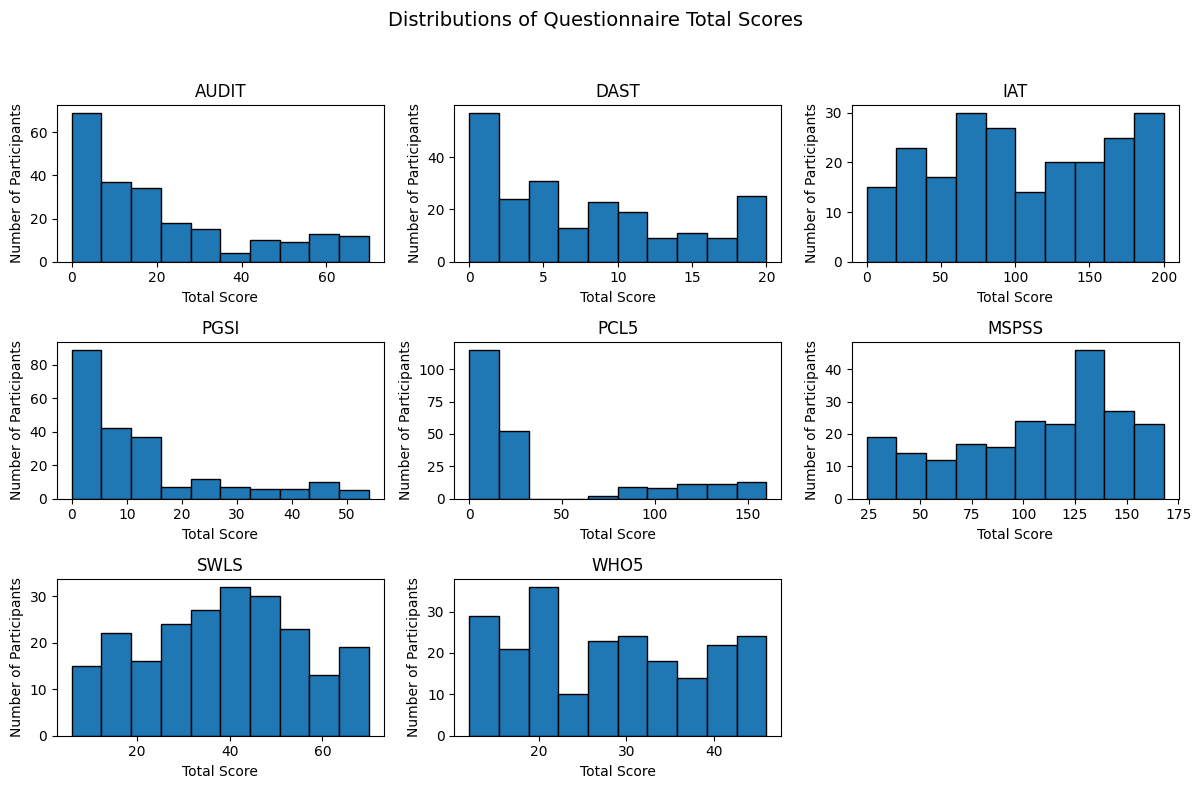

In [20]:
import matplotlib.pyplot as plt

# All columns that end with "_total"
totals = [c for c in df.columns if c.endswith("_total")]

# Create histograms for each total score
axes = df[totals].hist(
    bins=10,
    figsize=(12, 8),
    edgecolor='black',
    grid=False
)

# Add common labels
for ax in axes.flatten():
    ax.set_xlabel("Total Score")          # x-axis
    ax.set_ylabel("Number of Participants")  # y-axis
    ax.set_title(ax.get_title().replace("_total", "").upper())

plt.suptitle("Distributions of Questionnaire Total Scores", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

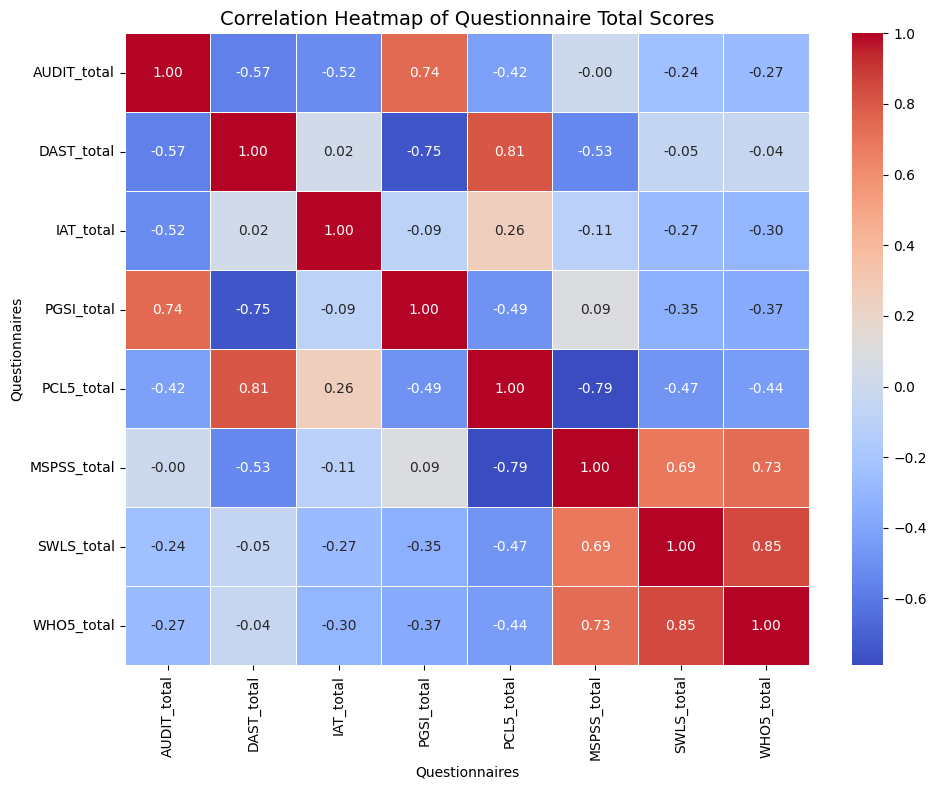

In [21]:
import seaborn as sns


# Select only the total score columns
totals = [c for c in df.columns if c.endswith("_total")]

# Compute the correlation matrix
corr = df[totals].corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    corr,
    annot=True,           # show the correlation values
    cmap="coolwarm",      # color palette (blue = negative, red = positive)
    fmt=".2f",            # format numbers to 2 decimals
    linewidths=0.5
)

plt.title("Correlation Heatmap of Questionnaire Total Scores", fontsize=14)
plt.xlabel("Questionnaires")
plt.ylabel("Questionnaires")
plt.tight_layout()
plt.show()

Co-occurrence of addictions: Alcohol and gambling problems tend to appear together (shared behavioral tendencies).

Different addiction profiles: Drug use (DAST) behaves differently from alcohol/gambling, possibly indicating a separate risk group.

Mental-health context: PTSD symptoms (PCL5) correlate positively with substance-use problems and negatively with social support and well-being.

Protective factors: High social support (MSPSS) and life satisfaction (SWLS/WHO5) move together and counterbalance addiction and trauma scores.